In [1]:
import pandas as pd
import altair as alt
import numpy as np

# Setup
alt.data_transformers.disable_max_rows()
alt.renderers.enable("mimetype")

# Load data
earthquakes = pd.read_csv('../../../data/processed/ordinal_data.csv')

In [2]:
# ----------
# DATA PREPARATION
# ----------
def extract_region(place_str):
    """Extract geographic region from place description"""
    if pd.isna(place_str):
        return 'Unknown'
    place_lower = str(place_str).lower()
    
    if ', ca' in place_lower or 'california' in place_lower:
        return 'California'
    elif 'alaska' in place_lower or ', ak' in place_lower:
        return 'Alaska'
    elif ', wa' in place_lower or 'washington' in place_lower or ', or' in place_lower or 'oregon' in place_lower:
        return 'Pacific NW'
    elif ', nv' in place_lower or 'nevada' in place_lower:
        return 'Nevada'
    elif 'hawaii' in place_lower or ', hi' in place_lower:
        return 'Hawaii'
    else:
        return 'Other US'

earthquakes['region'] = earthquakes['place'].apply(extract_region)

# Station count bins
earthquakes['nst_bin'] = pd.cut(
    earthquakes['nst'],
    bins=[-np.inf, 5, 10, 20, 50, np.inf],
    labels=['≤5', '6-10', '11-20', '21-50', '>50']
)

# Small event indicator
earthquakes['is_small'] = (earthquakes['mag'] < 3.0).astype(int)

# Monitoring quality score (0-1)
earthquakes['monitoring_score'] = (
    (earthquakes['nst'] / earthquakes['nst'].quantile(0.95)) +
    (1 - earthquakes['gap'] / earthquakes['gap'].max()) +
    (1 - earthquakes['dmin'] / earthquakes['dmin'].quantile(0.95))
) / 3
earthquakes['monitoring_score'] = earthquakes['monitoring_score'].clip(0, 1)

earthquakes['monitoring_quality'] = pd.cut(
    earthquakes['monitoring_score'],
    bins=[-np.inf, 0.3, 0.5, 0.7, np.inf],
    labels=['Poor', 'Fair', 'Good', 'Excellent']
)

# Filter to reasonable ranges
earthquakes_clean = earthquakes[
    (earthquakes['mag'] >= -1) &
    (earthquakes['mag'] <= 6) &
    (earthquakes['nst'] <= 150)
].copy()

print(f"Working with {len(earthquakes_clean):,} events")
print(f"Magnitude range: {earthquakes_clean['mag'].min():.2f} - {earthquakes_clean['mag'].max():.2f}")
print(f"Small events (<3.0): {earthquakes_clean['is_small'].sum():,} ({earthquakes_clean['is_small'].mean()*100:.1f}%)")


Working with 6,230 events
Magnitude range: -1.00 - 6.00
Small events (<3.0): 5,314 (85.3%)


In [3]:
# ----------
# INTERACTION DEFINITIONS
# ----------

# IMI/UI Widget #3: Dropdown for region selection
region_dropdown = alt.binding_select(
    options=[None] + ['California', 'Alaska', 'Pacific NW', 'Nevada', 'Hawaii', 'Other US'],
    labels=['All Regions', 'California', 'Alaska', 'Pacific NW', 'Nevada', 'Hawaii', 'Other US'],
    name='Region Filter: '
)
# region_selection = alt.selection_point(
#     fields=['region'],
#     bind=region_dropdown
# )

region_selection = alt.selection_point(
    fields=['region'],
    bind=region_dropdown,
    empty='all'
)

# Advanced DMI #3: Brush on scatter to select magnitude/station range
scatter_brush = alt.selection_interval(name='scatter_brush')

# Advanced DMI #4: Click on quality bars (bi-directional with scatter)
quality_click = alt.selection_point(
    fields=['monitoring_quality'],
    name='quality_selector'
)

In [4]:
# ----------
# VIZ 1: SCATTER - Detection Wedge (Main Chart)
# ----------
# Purpose: Show classic "detection wedge" - fewer stations = higher magnitude threshold
scatter = alt.Chart(earthquakes_clean).mark_circle(
    size=35,
    opacity=0.6,
    stroke='white',
    strokeWidth=0.3,
    clip=True
).encode(
    x=alt.X(
        'nst:Q',
        title='Number of Stations',
        scale=alt.Scale(domain=[0, 150], nice=True),
        axis=alt.Axis(grid=True, tickCount=6)
    ),
    y=alt.Y(
        'mag:Q',
        title='Magnitude',
        scale=alt.Scale(domain=[-1, 6], nice=True),
        axis=alt.Axis(grid=True)
    ),
    color=alt.condition(
        scatter_brush & quality_click,
        alt.Color(
            'monitoring_quality:O',
            title='Monitoring Quality',
            sort=['Poor', 'Fair', 'Good', 'Excellent'],
            scale=alt.Scale(
                domain=['Poor', 'Fair', 'Good', 'Excellent'],
                range=['#e74c3c', '#f39c12', '#3498db', '#27ae60']
            ),
            legend=alt.Legend(
                orient='none',
                legendX=540, legendY=-10,
                titleFontSize=12,
                labelFontSize=11,
                direction='horizontal',
                titleLimit=200
            )
        ),
        alt.value('lightgray')
    ),
    tooltip=[
        alt.Tooltip('nst:Q', title='Stations', format=',d'),
        alt.Tooltip('mag:Q', title='Magnitude', format='.2f'),
        alt.Tooltip('monitoring_quality:O', title='Quality'),
        alt.Tooltip('gap:Q', title='Gap (°)', format='.1f'),
        alt.Tooltip('region:N', title='Region'),
        alt.Tooltip('place:N', title='Location')
    ]
).transform_filter(
    region_selection
).transform_filter(
    quality_click
).add_params(
    scatter_brush,
    region_selection
).properties(
    width=520,
    height=360,
    title={
        "text": "Detection Wedge: Fewer Stations = Higher Magnitude Threshold",
        "fontSize": 14,
        "fontWeight": "bold",
        "subtitle": "Lower-left is empty: few stations cannot detect small events. Brush to select range - colors highlight selection.",
        "subtitleFontSize": 11
    }
)


In [13]:
# ----------
# VIZ 2: STACKED BAR - Station Count Distribution by Magnitude Bins (SIMPLIFIED)
# ----------
# Purpose: Show how station counts vary across magnitude ranges (simpler than histogram)
earthquakes_clean['mag_range'] = pd.cut(
    earthquakes_clean['mag'],
    bins=[-np.inf, 0, 1, 2, 3, 4, np.inf],
    labels=['<0', '0-1', '1-2', '2-3', '3-4', '>4']
)

# stacked_bars = alt.Chart(earthquakes_clean).mark_bar().encode(
#     x=alt.X(
#         'mag_range:N',  # Changed from :O to :N (nominal)
#         title='Magnitude Range',
#         sort=['<0', '0-1', '1-2', '2-3', '3-4', '>4'],
#         axis=alt.Axis(labelAngle=0)
#     ),
#     y=alt.Y(
#         'count():Q',
#         title='Number of Events',
#         axis=alt.Axis(grid=True, format=',d')
#     ),
#     color=alt.Color(
#         'nst_bin:N',
#         title='Station Count',
#         sort=['≤5', '6-10', '11-20', '21-50', '>50'],
#         scale=alt.Scale(scheme='blues'),
#         legend=alt.Legend(
#             orient='top',
#             titleFontSize=12,
#             labelFontSize=11,
#             direction='horizontal'
#         )
#     ),
#     tooltip=[
#         alt.Tooltip('mag_range:N', title='Magnitude Range'),
#         alt.Tooltip('nst_bin:N', title='Station Count'),
#         alt.Tooltip('count():Q', title='Events', format=',d')
#     ]
# ).transform_filter(
#     scatter_brush
# ).transform_filter(
#     region_selection
# ).transform_filter(
#     quality_click
# ).properties(
#     width=520,
#     height=220,
#     title={
#         "text": "Station Count Distribution Across Magnitude Ranges",
#         "fontSize": 14,
#         "fontWeight": "bold",
#         "subtitle": "Shows detection bias: small magnitudes dominated by high station counts. Filtered by brush selection above.",
#         "subtitleFontSize": 11
#     }
# )

stacked_bars = (
    alt.Chart(earthquakes_clean)
    .mark_bar()
    .encode(
        x=alt.X(
            'mag_range:N',
            title='Magnitude Range',
            sort=['<0', '0-1', '1-2', '2-3', '3-4', '>4'],
            axis=alt.Axis(labelAngle=0)
        ),
        y=alt.Y(
            'count():Q',
            title='Number of Events',
            axis=alt.Axis(grid=True, format=',d')
        ),
        color=alt.Color(
            'nst_bin:N',
            title='Station Count',
            sort=['≤5', '6-10', '11-20', '21-50', '>50'],
            scale=alt.Scale(scheme='blues'),
            legend=alt.Legend(
                orient='top',
                titleFontSize=12,
                labelFontSize=11,
                direction='horizontal'
            )
        ),
        tooltip=[
            alt.Tooltip('mag_range:N', title='Magnitude Range'),
            alt.Tooltip('nst_bin:N', title='Station Count'),
            alt.Tooltip('count():Q', title='Events', format=',d')
        ]
    )
    .transform_filter(scatter_brush)       # <-- MUST BE HERE
    .transform_filter(region_selection)    # <-- MUST BE HERE
    .transform_filter(quality_click)       # <-- MUST BE HERE
    .properties(
        width=520,
        height=220,
        title={
            "text": "Station Count Distribution Across Magnitude Ranges",
            "fontSize": 14,
            "fontWeight": "bold",
            "subtitle": "Shows detection bias. Filters: region, quality, and scatter brush.",
            "subtitleFontSize": 11
        }
    )
)

In [14]:
# ----------
# VIZ 3: BAR CHART - Monitoring Quality Distribution (Clickable)
# ----------
# Purpose: Show quality composition, click to filter scatter (bi-directional)
quality_bars = alt.Chart(earthquakes_clean).mark_bar(
    stroke='white',
    strokeWidth=1
).encode(
    x=alt.X(
        'count():Q',
        title='Number of Events',
        axis=alt.Axis(grid=True, format=',d')
    ),
    y=alt.Y(
        'monitoring_quality:O',
        title='Monitoring Quality',
        sort=['Excellent', 'Good', 'Fair', 'Poor'],
        axis=alt.Axis(labelFontSize=11)
    ),
    color=alt.Color(
        'monitoring_quality:O',
        scale=alt.Scale(
            domain=['Poor', 'Fair', 'Good', 'Excellent'],
            range=['#e74c3c', '#f39c12', '#3498db', '#27ae60']
        ),
        legend=None
    ),
    opacity=alt.condition(quality_click, alt.value(1.0), alt.value(0.3)),
    tooltip=[
        alt.Tooltip('monitoring_quality:O', title='Quality'),
        alt.Tooltip('count():Q', title='Events', format=',d'),
        alt.Tooltip('mean(mag):Q', title='Avg Magnitude', format='.2f'),
        alt.Tooltip('mean(nst):Q', title='Avg Stations', format='.1f')
    ]
).transform_filter(
    scatter_brush
).transform_filter(
    region_selection
).add_params(
    quality_click
).properties(
    width=240,
    height=220,
    title={
        "text": "Quality Distribution",
        "fontSize": 14,
        "fontWeight": "bold",
        "subtitle": "Click bars to filter scatter (bi-directional)",
        "subtitleFontSize": 11
    }
)

In [15]:
# ----------
# VIZ 4: HEATMAP - Detection Bias (Small Event Rate)
# ----------
# Purpose: Quantify detection bias with exact percentages
# Pre-calculate small event rates
detection_summary = earthquakes_clean.groupby(['nst_bin', 'monitoring_quality']).agg({
    'is_small': ['sum', 'count']
}).reset_index()
detection_summary.columns = ['nst_bin', 'monitoring_quality', 'small_events', 'total_events']
detection_summary['small_event_rate'] = detection_summary['small_events'] / detection_summary['total_events']

# Heatmap with lighter color scheme
detection_heatmap = alt.Chart(detection_summary).mark_rect(
    stroke='white',
    strokeWidth=1.5
).encode(
    x=alt.X(
        'nst_bin:O',
        title='Station Count',
        sort=['≤5', '6-10', '11-20', '21-50', '>50'],
        axis=alt.Axis(labelAngle=0, labelFontSize=11)
    ),
    y=alt.Y(
        'monitoring_quality:O',
        title='Monitoring Quality',
        sort=['Excellent', 'Good', 'Fair', 'Poor'],
        axis=alt.Axis(labelFontSize=11)
    ),
    color=alt.Color(
        'small_event_rate:Q',
        title='% Small Events',
        scale=alt.Scale(
            scheme='yellowgreenblue',
            domain=[0.2, 1.0]
        ),
        legend=alt.Legend(
            orient='top',
            titleFontSize=12,
            labelFontSize=11,
            format='.0%',
            gradientLength=180,
            direction='horizontal'
        )
    ),
    tooltip=[
        alt.Tooltip('nst_bin:O', title='Station Count'),
        alt.Tooltip('monitoring_quality:O', title='Quality'),
        alt.Tooltip('small_event_rate:Q', title='Small Event %', format='.1%'),
        alt.Tooltip('small_events:Q', title='Small Events', format=',d'),
        alt.Tooltip('total_events:Q', title='Total Events', format=',d')
    ]
).properties(
    width=240,
    height=220,
    title={
        "text": "Detection Bias Rates",
        "fontSize": 14,
        "fontWeight": "bold",
        "subtitle": "% of events <M3.0. Shows 3-4× difference.",
        "subtitleFontSize": 11
    }
)

# Add text annotations
text_annotations = detection_heatmap.mark_text(
    fontSize=11,
    fontWeight='bold'
).encode(
    text=alt.Text('small_event_rate:Q', format='.0%'),
    color=alt.condition(
        alt.datum.small_event_rate > 0.6,
        alt.value('white'),
        alt.value('black')
    ),
    tooltip=alt.value(None)
)

detection_heatmap_final = detection_heatmap + text_annotations


/var/folders/g0/j1684vkx21q53x13glv0mjl00000gn/T/ipykernel_56630/3667750075.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  detection_summary = earthquakes_clean.groupby(['nst_bin', 'monitoring_quality']).agg({


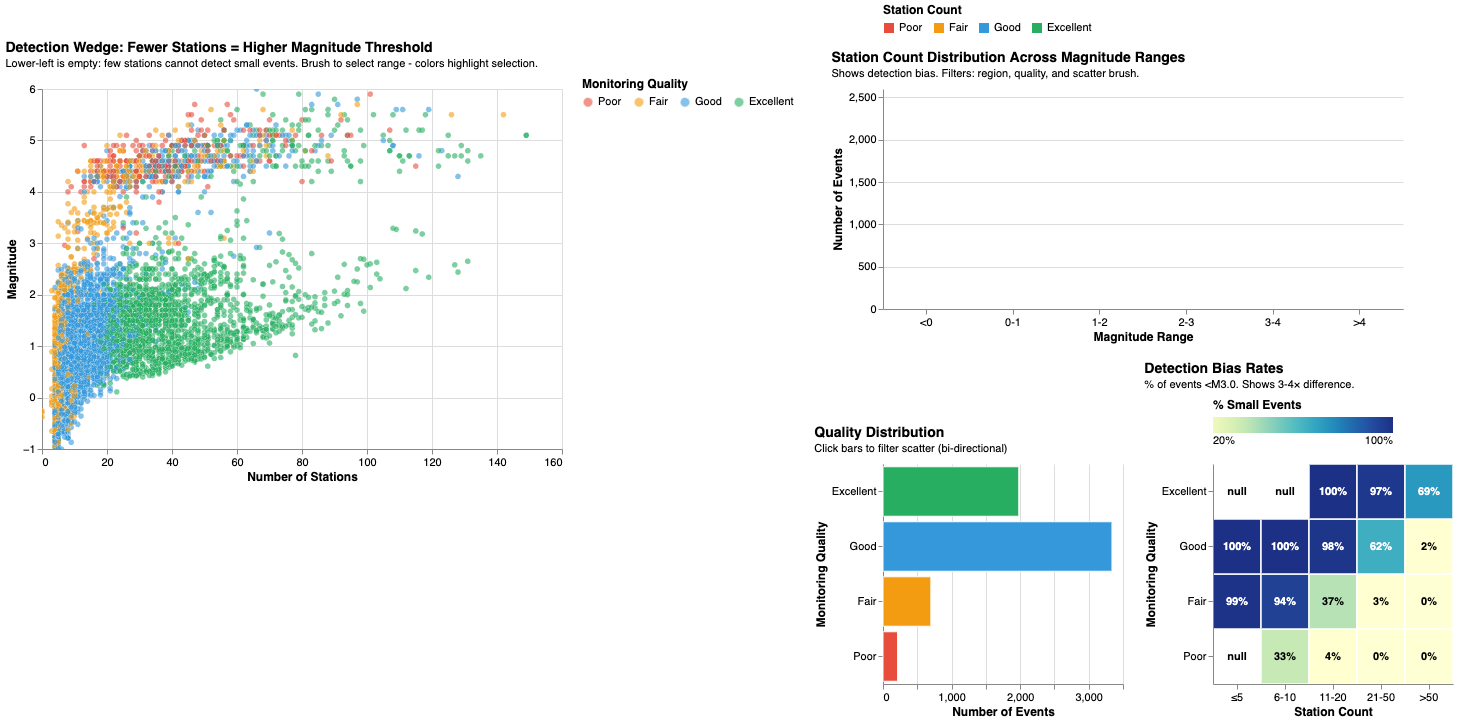

In [16]:
# FINAL LAYOUT
# ----------
# Side-by-side layout to avoid scrolling
# Left: Large scatter (primary exploration)
# Right: Stacked bars (top) + Quality bars + Heatmap (bottom)

right_column = stacked_bars & (quality_bars | detection_heatmap_final)

view2 = (scatter | right_column).configure_view(
    strokeWidth=0
).configure_axis(
    labelFontSize=11,
    titleFontSize=12
).configure_legend(
    titleFontSize=12,
    labelFontSize=11
).configure_title(
    fontSize=14,
    anchor='start',
    offset=10
)

view2